In [80]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import glob
import natsort
import tifffile as tiff


In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [83]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_raw = r'Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\PLA\HCC827 cell culture'


# Read imgs

In [84]:
df_imgs_path = data_dir / '9PPI Cell Culture' / '3D_Whole' /  'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_imgs_path)
df_imgs.head()

,Timepoint,FOV,Z,Path
0,HCC827Ctrl,FW1,0,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
1,HCC827Ctrl,FW1,1,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
2,HCC827Ctrl,FW1,2,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
3,HCC827Ctrl,FW1,3,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...
4,HCC827Ctrl,FW1,4,Y:\coskun-lab\Thomas\15_PLA\data\9PPI Cell Cul...


In [85]:
df_subset = df_imgs[(df_imgs['Timepoint'] == 'HCC827Ctrl') & (df_imgs['FOV'] == 'FW1')]

x_min, x_max = 1700, 2700
y_min, y_max = 1000, 1900

x_min2, x_max2 = 585, 709
y_min2, y_max2 = 330, 461

x_max = x_min + x_max2
x_min = x_min+x_min2
y_max = y_min + y_max2
y_min = y_min+y_min2

print(x_min, x_max, y_min, y_max)

imgs = []
n_limit = 5

for row in tqdm(df_subset.itertuples(), total=len(df_subset)):
    # Read images
    path = row.Path
    with h5py.File(path, "r") as f:
        img = f['imgs'][:, y_min: y_max, x_min:x_max]
        markers = f['imgs'].attrs['Marker']

    imgs.append(img)

imgs = imgs[n_limit:-n_limit]

2285 2409 1330 1461


  0%|          | 0/24 [00:00<?, ?it/s]

In [86]:
# import napari

# napari.view_image(np.stack(imgs), name=markers, channel_axis=1, visible=False, contrast_limits=[0, 65000])

# Read 3D PPI information

In [87]:
import pickle 
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import scipy 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def get_NN_radius(data, r):
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=True, sort_results=True)

    # Put in dataframe format
    neighbours = pd.DataFrame(m[1].tolist(), index = data.index)
    
    A = fit.radius_neighbors_graph(data)
    return neighbours, A  

In [88]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / '9PPI Cell Culture' / '3D_Whole' / 'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

PPI_save_path =  data_dir / '9PPI Cell Culture' / '3D_Whole'  / 'PPI'

In [89]:
names = ['HCC827Ctrl', 'FW1']
name = '_'.join(names)

# Read PPi
PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

PPI =  ['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4', 'Bim & Tom20', 'Mcl-1 & BAK', 
            'p-ERK & c-MYC', 'TEAD1 & YAP',  'Cyclin E & CDK4', 'P-AKT & mTOR']
PPI_marker = 'Cyclin D1 & CDK2'
indice_marker = list(markers).index(PPI_marker)

PPI_loc = PPI_dict[PPI_marker][:, :3].astype(np.uint32)

# Filter by position
PPI_loc = PPI_loc[(PPI_loc[:, 1] > y_min) & (PPI_loc[:, 1] < y_max) & (PPI_loc[:, 2] > x_min) & (PPI_loc[:, 2] < x_max)]
PPI_loc = PPI_loc - np.array([0, y_min, x_min])

imgs_subset = np.stack(imgs)[:, [0, indice_marker],...]

In [90]:
# Get PPI loc in panda dataframe format
df_loc = pd.DataFrame(PPI_loc, columns=['z', 'y', 'x'])

# Get dot neighboring graph with user defined radius
nei, A = get_NN_radius(df_loc[['y', 'x']], r=2.5)

# Assign new labels based on connected components label
labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
df_loc['CC_label'] = labels

# Group by CC and extract mean position
df_loc_filtered = df_loc.groupby(['CC_label']).mean().astype(np.uint32)
PPI_loc_filt = df_loc_filtered.values

In [91]:
import napari

viewer = napari.view_image(imgs_subset, name=['DAPI', PPI_marker], channel_axis=1, visible=False, contrast_limits=[0, 65000])
points_layer = viewer.add_points(PPI_loc, size=2, face_color='red')
points_layer = viewer.add_points(PPI_loc_filt, size=2, face_color='blue')

In [104]:
df_filt_count = df_loc_filtered.groupby('z', as_index=False).size()
df_filt_count.columns=['z', 'Count']
df_filt_count['Type'] = 'Radius matched'
df_count = df_loc.groupby('z', as_index=False).size()
df_count.columns=['z', 'Count']
df_count['Type'] = 'Raw'

df_all = pd.concat([df_count, df_filt_count])
# df_all = df_all[df_all.z < 5]
df_all['z'] = df_all['z'].astype(int)

In [105]:
df_all

,z,Count,Type
0,0,66,Raw
1,1,67,Raw
2,2,55,Raw
3,3,47,Raw
4,4,38,Raw
5,5,38,Raw
6,6,35,Raw
7,7,28,Raw
8,8,28,Raw
9,9,39,Raw


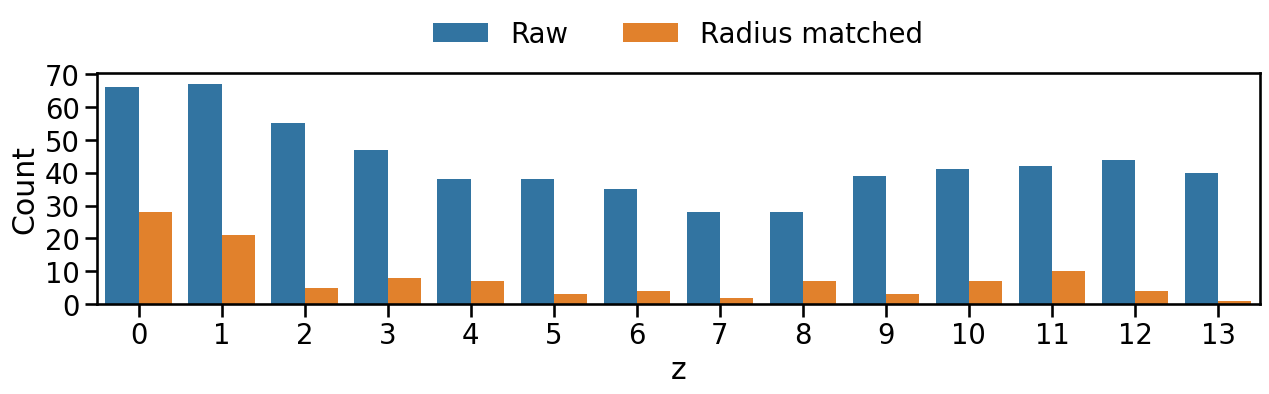

In [109]:
import seaborn as sns

with sns.plotting_context('talk', font_scale=1.2):
    fig, axs = plt.subplots(figsize=(15,3))
    ax = sns.barplot(data=df_all, x='z', y='Count', hue='Type')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)



# Example showing different radius matched for PPI event

In [148]:
import pickle 
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import scipy 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def get_NN_radius(data, r):
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=True, sort_results=True)

    # Put in dataframe format
    neighbours = pd.DataFrame(m[1].tolist(), index = data.index)
    
    A = fit.radius_neighbors_graph(data)
    return neighbours, A  

In [116]:
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [111]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / '9PPI Cell Culture' / '3D_Whole' / 'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

PPI_save_path =  data_dir / '9PPI Cell Culture' / '3D_Whole'  / 'PPI'

In [147]:
names = ['HCC827Ctrl', 'FW1']
name = '_'.join(names)

# Read PPi
PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

PPI =  ['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4', 'Bim & Tom20', 'Mcl-1 & BAK', 
            'p-ERK & c-MYC', 'TEAD1 & YAP',  'Cyclin E & CDK4', 'P-AKT & mTOR']
PPI_marker = 'Cyclin D1 & CDK2'
indice_marker = list(markers).index(PPI_marker)

PPI_loc = PPI_dict[PPI_marker][:, :3].astype(np.uint32)

# Filter by position
PPI_loc = PPI_loc[(PPI_loc[:, 1] > y_min) & (PPI_loc[:, 1] < y_max) & (PPI_loc[:, 2] > x_min) & (PPI_loc[:, 2] < x_max)]
PPI_loc = PPI_loc - np.array([0, y_min, x_min])

imgs_subset = np.stack(imgs)[:, [0, indice_marker],...]

In [180]:
# Get PPI loc in panda dataframe format
df_loc = pd.DataFrame(PPI_loc, columns=['z', 'y', 'x'])

### R = 2.5
# Get dot neighboring graph with user defined radius
nei, A = get_NN_radius(df_loc[['y', 'x']], r=2.5)

# Assign new labels based on connected components label
labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
df_loc['CC_label'] = labels
print(len(np.unique(labels)))

# Group by CC and extract mean position
df_loc_filtered_25 = df_loc.groupby(['CC_label']).mean().astype(np.uint32)
PPI_loc_filt_25 = df_loc_filtered_25.values

### R =  1
# Get dot neighboring graph with user defined radius
nei, A = get_NN_radius(df_loc[['y', 'x']], r=1)

# Assign new labels based on connected components label
labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
df_loc['CC_label'] = labels
print(len(np.unique(labels)))

# Group by CC and extract mean position
df_loc_filtered_1 = df_loc.groupby(['CC_label']).mean().astype(np.uint32)
PPI_loc_filt_1 = df_loc_filtered_1.values.copy()

### R = 10
### R =  1
# Get dot neighboring graph with user defined radius
nei, A = get_NN_radius(df_loc[['y', 'x']], r=10)

# Assign new labels based on connected components label
labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
df_loc['CC_label'] = labels
print(len(np.unique(labels)))

# Group by CC and extract mean position
df_loc_filtered_10 = df_loc.groupby(['CC_label']).mean().astype(np.uint32)
PPI_loc_filt_10 = df_loc_filtered_10.values

110
210
22


In [181]:
# import napari

# viewer = napari.view_image(imgs_subset, name=['DAPI', PPI_marker], channel_axis=1, visible=False, contrast_limits=[0, 65000])
# points_layer = viewer.add_points(PPI_loc, size=5, face_color='red')
# points_layer = viewer.add_points(PPI_loc_filt_1, size=5, face_color='blue')
# points_layer = viewer.add_points(PPI_loc_filt_10, size=5, face_color='magenta')
# points_layer = viewer.add_points(PPI_loc_filt_25, size=5, face_color='green')

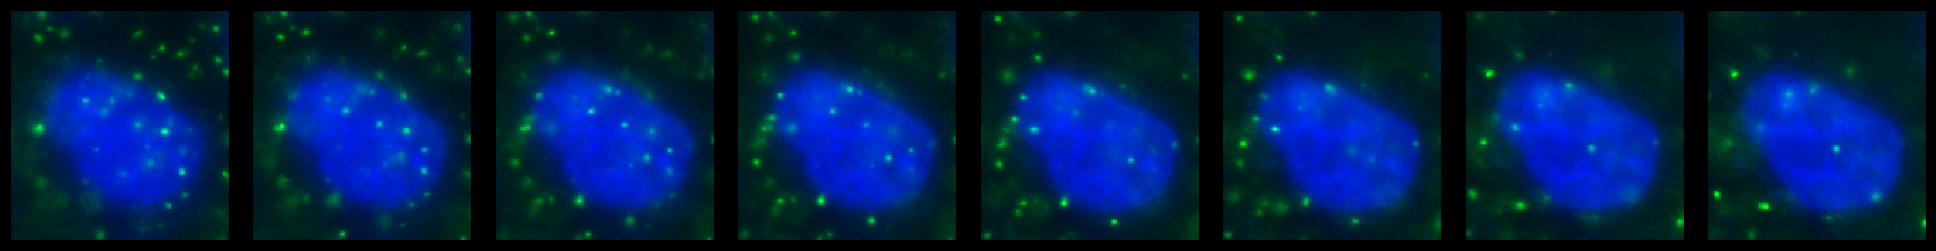

In [187]:
viewer = napari.view_image(imgs_subset, name=['DAPI', PPI_marker], colormap=['blue', 'green'], channel_axis=1, contrast_limits=[0, 25000])
n = 8
fig, axs = plt.subplots(1,n, figsize=(25,3))
for i in range(n):
    viewer.dims.set_point(0, i)
    screenshot = viewer.screenshot(size=np.array(imgs_subset[0,0].shape)*2)
    screenshot = removeBorders(screenshot)
    axs[i].imshow(screenshot)
    axs[i].axis('off')
fig.subplots_adjust(wspace=0.01)
fig.set_facecolor('k')
viewer.close()
plt.show()


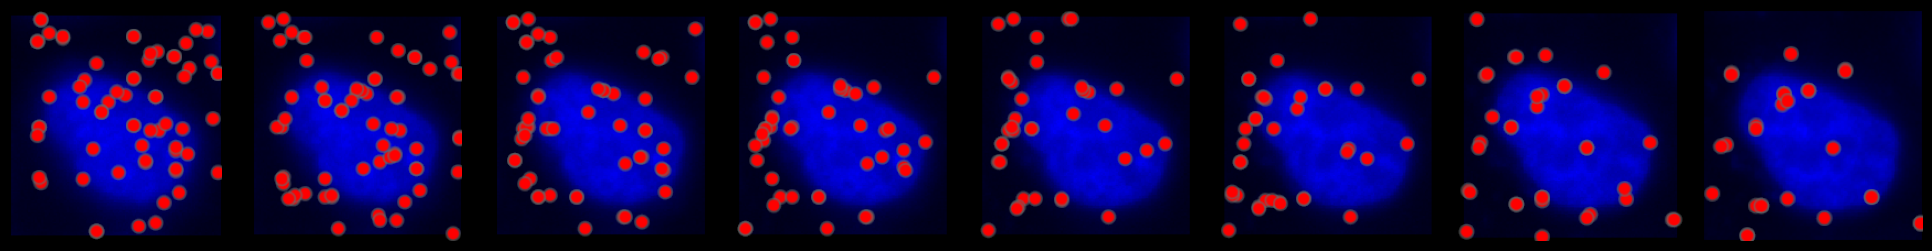

In [188]:
viewer = napari.view_image(imgs_subset[:,0,...], colormap='blue',  contrast_limits=[0, 25000])
points_layer = viewer.add_points(PPI_loc, size=8, face_color='red')

n = 8
fig, axs = plt.subplots(1,n, figsize=(25,3))
for i in range(n):
    viewer.dims.set_point(0, i)
    screenshot = viewer.screenshot(size=np.array(imgs_subset[0,0].shape)*2)
    screenshot = removeBorders(screenshot)
    axs[i].imshow(screenshot)
    axs[i].axis('off')
fig.subplots_adjust(wspace=0.01)
fig.set_facecolor('k')
viewer.close()
plt.show()


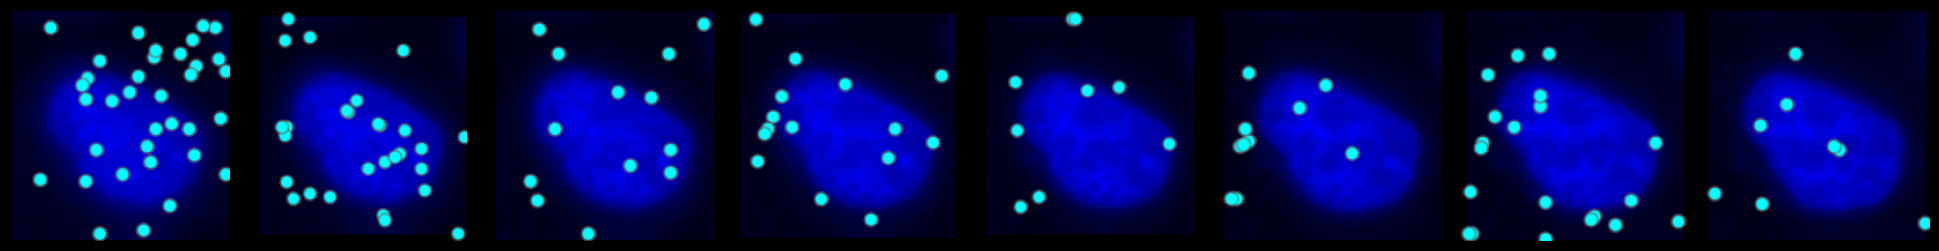

In [189]:
viewer = napari.view_image(imgs_subset[:,0,...], colormap='blue',  contrast_limits=[0, 25000])
points_layer = viewer.add_points(PPI_loc_filt_1, size=8, face_color='cyan')

n = 8
fig, axs = plt.subplots(1,n, figsize=(25,3))
for i in range(n):
    viewer.dims.set_point(0, i)
    screenshot = viewer.screenshot(size=np.array(imgs_subset[0,0].shape)*2)
    screenshot = removeBorders(screenshot)
    axs[i].imshow(screenshot)
    axs[i].axis('off')
fig.subplots_adjust(wspace=0.01)
fig.set_facecolor('k')
viewer.close()
plt.show()


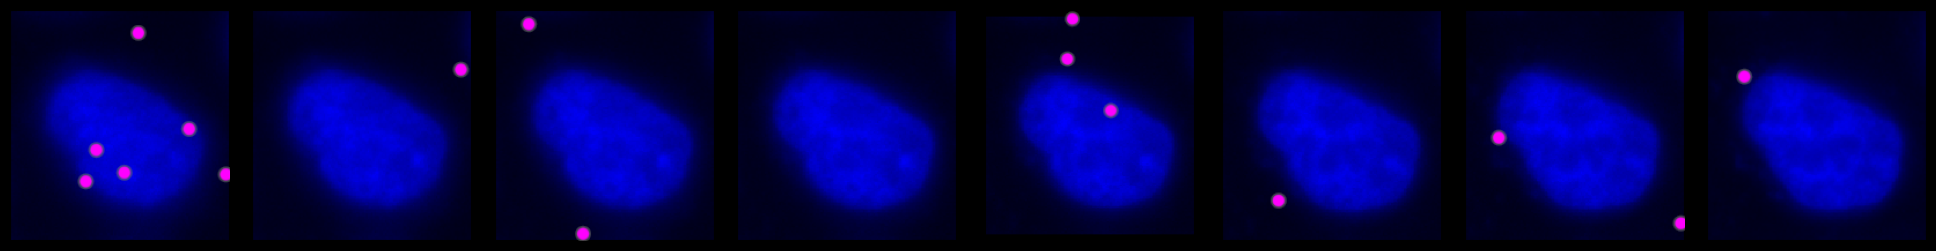

In [190]:
viewer = napari.view_image(imgs_subset[:,0,...], colormap='blue',  contrast_limits=[0, 25000])
points_layer = viewer.add_points(PPI_loc_filt_10, size=8, face_color='magenta')

n = 8
fig, axs = plt.subplots(1,n, figsize=(25,3))
for i in range(n):
    viewer.dims.set_point(0, i)
    screenshot = viewer.screenshot(size=np.array(imgs_subset[0,0].shape)*2)
    screenshot = removeBorders(screenshot)
    axs[i].imshow(screenshot)
    axs[i].axis('off')
fig.subplots_adjust(wspace=0.01)
fig.set_facecolor('k')
viewer.close()
plt.show()


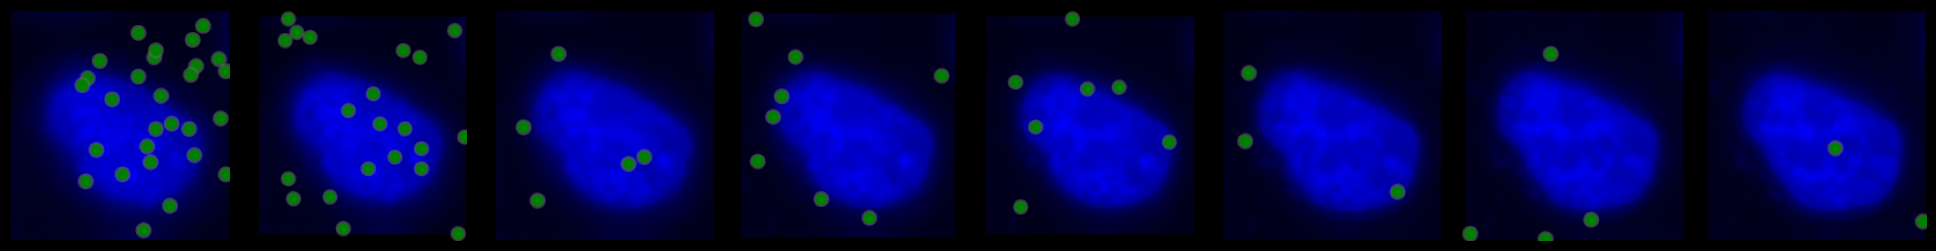

In [191]:
viewer = napari.view_image(imgs_subset[:,0,...], colormap='blue',  contrast_limits=[0, 25000])
points_layer = viewer.add_points(PPI_loc_filt_25, size=8, face_color='green')

n = 8
fig, axs = plt.subplots(1,n, figsize=(25,3))
for i in range(n):
    viewer.dims.set_point(0, i)
    screenshot = viewer.screenshot(size=np.array(imgs_subset[0,0].shape)*2)
    screenshot = removeBorders(screenshot)
    axs[i].imshow(screenshot)
    axs[i].axis('off')
fig.subplots_adjust(wspace=0.01)
fig.set_facecolor('k')
viewer.close()
plt.show()


In [264]:
df_filt_count_10 = df_loc_filtered_10.groupby('z', as_index=False).size()
df_filt_count_10.columns=['z', 'Count']
df_filt_count_10['Type'] = '10 Pixels'
df_filt_count_1 = df_loc_filtered_1.groupby('z', as_index=False).size()
df_filt_count_1.columns=['z', 'Count']
df_filt_count_1['Type'] = '1 Pixels'
df_filt_count_25 = df_loc_filtered_25.groupby('z', as_index=False).size()
df_filt_count_25.columns=['z', 'Count']
df_filt_count_25['Type'] = '2.5 Pixels'
df_count = df_loc.groupby('z', as_index=False).size()
df_count.columns=['z', 'Count']
df_count['Type'] = 'Raw'

df_all = pd.concat([df_count, df_filt_count_1, df_filt_count_25, df_filt_count_10])
df_all = df_all[df_all.z < n]
df_all['z'] = df_all['z'].astype(int)

In [265]:
df_all

,z,Count,Type
0,0,66,Raw
1,1,67,Raw
2,2,55,Raw
3,3,47,Raw
4,4,38,Raw
5,5,38,Raw
6,6,35,Raw
7,7,28,Raw
0,0,35,1 Pixels
1,1,28,1 Pixels


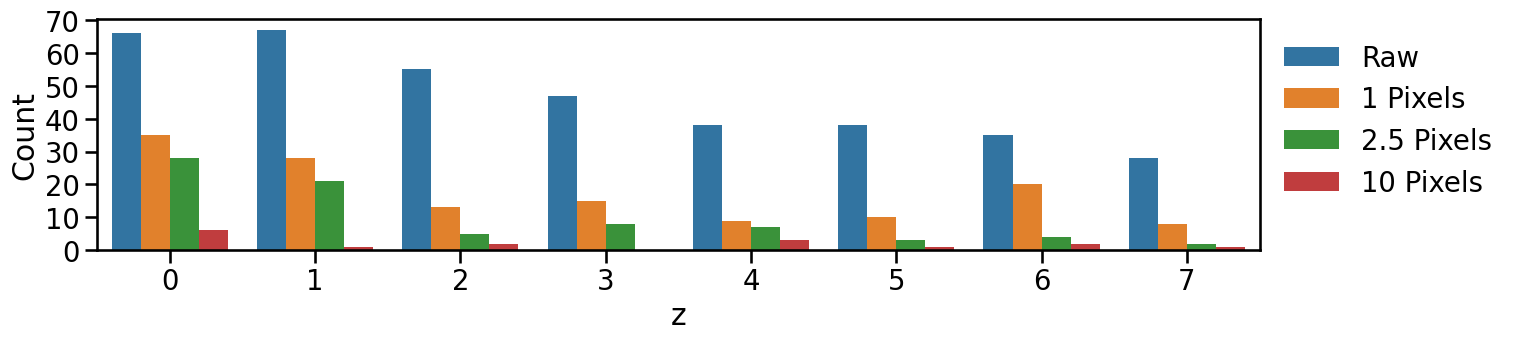

In [269]:
import seaborn as sns

with sns.plotting_context('talk', font_scale=1.2):
    fig, axs = plt.subplots(figsize=(15,3))
    ax = sns.barplot(data=df_all, x='z', y='Count', hue='Type')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False)



# Plot network

In [204]:
import networkx as nx 

def plot_network(g, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, with_labels=False, ax=ax, **kwargs)
    return ax

In [238]:
df_subset 

,z,y,x,CC_label
0,0,68,87,0
1,0,48,85,0
2,0,92,97,0
3,0,66,16,1
4,0,21,86,0
...,...,...,...,...
268,4,109,31,12
269,4,115,20,12
270,4,1,18,5
271,4,65,73,0


<Axes: >

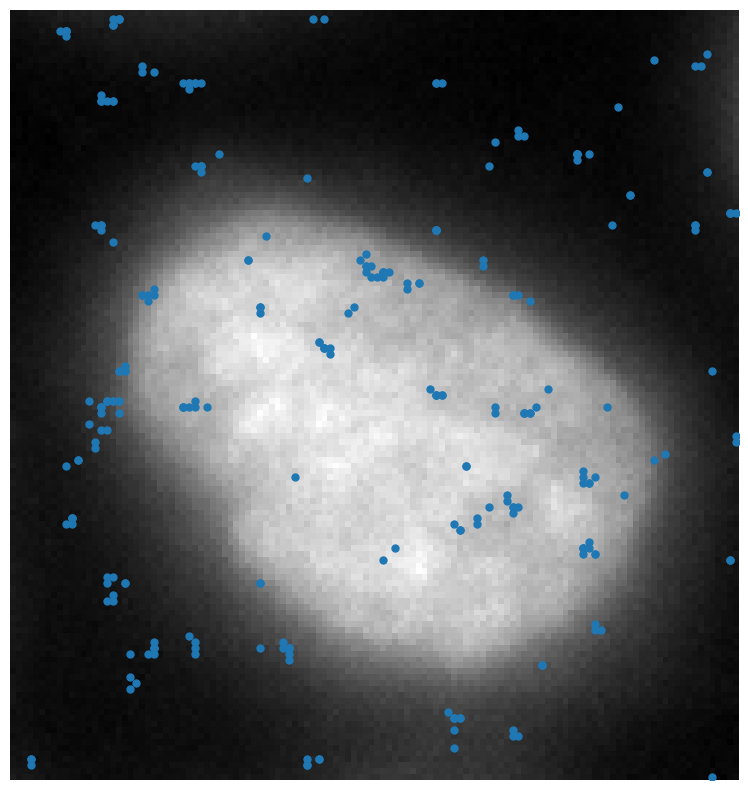

In [251]:
df_subset = df_loc[(df_loc.z < 5)]
y,x = df_subset['y'].to_numpy(), df_subset['x'].to_numpy()
# Get coordinates
coordinates = np.vstack([y,x]).T

# Create graphs
G= nx.Graph()
G.add_nodes_from([i for i in range(len(df_subset))])
nx.set_node_attributes(G, dict(zip(G.nodes(), coordinates)), "pos")

# Get coordinates
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imgs_subset[0,0,...], cmap='gray')
plot_network(G, ax, node_size=25, width=3, edge_color='w')


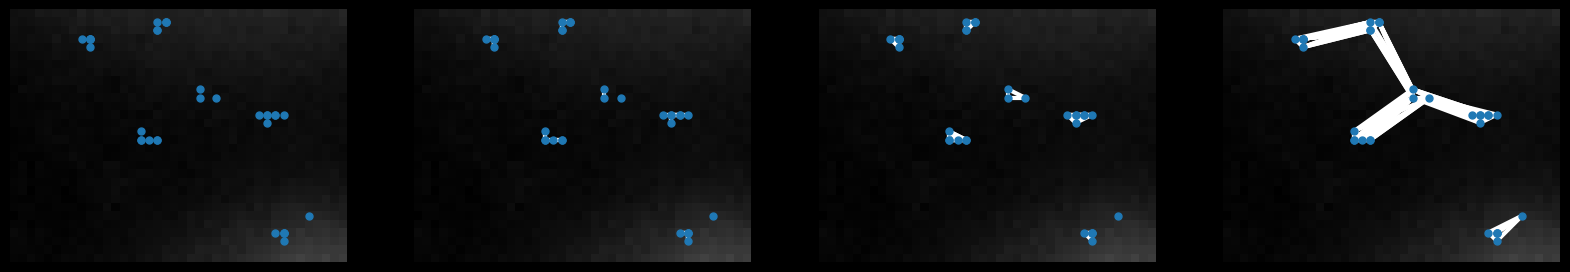

In [259]:
x_max = 40
y_max = 30
df_subset = df_loc[(df_loc.z < 5) & (df_loc.x < x_max) & (df_loc.y < y_max) ]
y,x = df_subset['y'].to_numpy(), df_subset['x'].to_numpy()
# Get coordinates
coordinates = np.vstack([y,x]).T

img = imgs_subset[0,0,:y_max, :x_max]

# Create graphs
G= nx.Graph()
G.add_nodes_from([i for i in range(len(df_subset))])
nx.set_node_attributes(G, dict(zip(G.nodes(), coordinates)), "pos")

f, axs = plt.subplots(1, 4, figsize=(20,5))
for i, r in enumerate([0, 1, 2.5, 10]):
    ### R = 2.5
    # Get dot neighboring graph with user defined radius
    nei, A = get_NN_radius(df_subset[['y', 'x']], r=r)

    G= nx.from_numpy_array(A)
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.set_node_attributes(G, dict(zip(G.nodes(), coordinates)), "pos")

    axs[i].imshow(img,  cmap='gray', vmax=25000)
    axs[i].axis('off')
    plot_network(G, axs[i], node_size=25, width=3, edge_color='w')

# f.subplots_adjust(wspace=0)
f.set_facecolor('k')


C:\Users\thu71\AppData\Local\Temp\ipykernel_65092\3376076816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['CC_label'] = labels
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
C:\Users\thu71\AppData\Local\Temp\ipykernel_65092\3376076816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

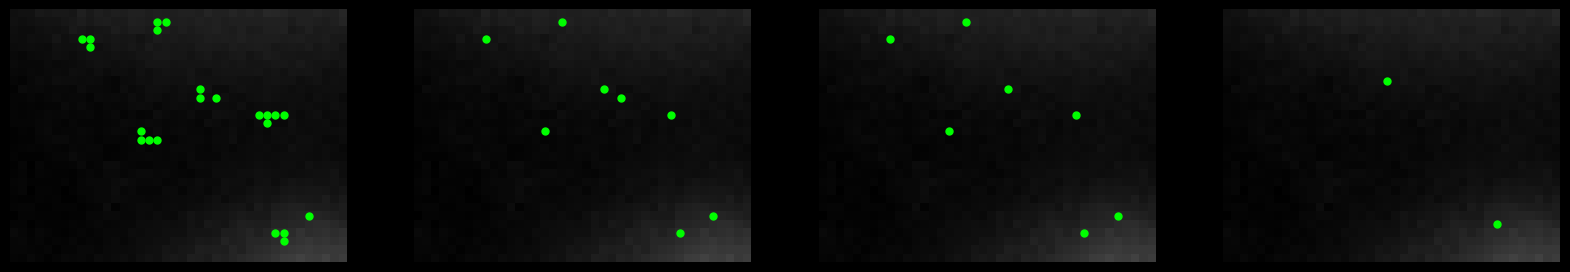

In [275]:
x_max = 40
y_max = 30
df_subset = df_loc[(df_loc.z < 5) & (df_loc.x < x_max) & (df_loc.y < y_max) ]

f, axs = plt.subplots(1, 4, figsize=(20,5))
for i, r in enumerate([0, 1, 2.5, 10]):
    ### R = 2.5
    # Get dot neighboring graph with user defined radius
    nei, A = get_NN_radius(df_subset[['y', 'x']], r=r)
    # Assign new labels based on connected components label
    labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
    df_subset['CC_label'] = labels
    
    # Group by CC and extract mean position
    df_loc_filtered = df_subset.groupby(['CC_label']).mean().astype(np.uint32)
    nei, A = get_NN_radius(df_loc_filtered[['y', 'x']], r=r)
    y,x = df_loc_filtered['y'].to_numpy(), df_loc_filtered['x'].to_numpy()
    # Get coordinates
    coordinates = np.vstack([y,x]).T

    G= nx.from_numpy_array(A)
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.set_node_attributes(G, dict(zip(G.nodes(), coordinates)), "pos")

    axs[i].imshow(img,  cmap='gray', vmax=25000)
    axs[i].axis('off')
    plot_network(G, axs[i], node_color=[0, 1, 0], node_size=25, width=3, edge_color='w')

# f.subplots_adjust(wspace=0)
f.set_facecolor('k')
